In [1]:
import numpy as np
import pandas as pd
import shap
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn_pandas import DataFrameMapper
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Leer datos
data = pd.read_csv('../data/PROCESS/processed_tch_prediction_data_2Mesv7.csv')

# Crear una máscara para ZAFRA 23-24
mask_23_24 = data['ZAFRA'] == '23-24'

# Dividir los datos en entrenamiento y prueba
X_train = data[~mask_23_24].drop('TCH', axis=1)
y_train = data[~mask_23_24]['TCH']
X_test = data[mask_23_24].drop('TCH', axis=1)
y_test = data[mask_23_24]['TCH']

# Eliminar columnas innecesarias
X_train = X_train.drop(columns=['ABS_IDCOMP', 'ZAFRA', 'fecha', 'rendimiento'])
X_test = X_test.drop(columns=['ABS_IDCOMP', 'ZAFRA', 'fecha', 'rendimiento'])

print("\nDivisión ZAFRA:")
print(f"Forma del conjunto de entrenamiento: {X_train.shape}")
print(f"Forma del conjunto de prueba: {X_test.shape}")

# Definir grupos de columnas
column_group_3 = ['tipo_cosecha']
column_group_2 = ['prod_mad', 'estacion', 'variedad', 'numero_corte', 'sist_riego', 'region', 'estrato', 'cuadrante', 'PRODUCTO_ACTUAL']

column_group_1 = [
    ['ETP_Q2_mean'], ['ETP_Q2_std'], ['Radiacion (MJ/m2)_Q2_mean'], ['Radiacion (MJ/m2)_Q2_std'],
    ['Amplitud Térmica_Q2_mean'], ['Amplitud Térmica_Q2_std'], ['R0_Q2_mean'], ['R0_Q2_std'],
    ['temperatura_Q2_mean'], ['temperatura_Q2_std'], ['humedad relativa_Q2_mean'], ['humedad relativa_Q2_std'],
    ['humedad relativa minima_Q2_mean'], ['humedad relativa minima_Q2_std'], ['humedad relativa maxima_Q2_mean'],
    ['humedad relativa maxima_Q2_std'], ['precipitacion_Q2_mean'], ['precipitacion_Q2_std'],
    ['velocidad viento_Q2_mean'], ['velocidad viento_Q2_std'], ['velocidad viento minima_Q2_mean'],
    ['velocidad viento minima_Q2_std'], ['velocidad viento maxima_Q2_mean'], ['velocidad viento maxima_Q2_std'],
    ['direccion viento_Q2_mean'], ['direccion viento_Q2_std'], ['NDVI_POND_Q2_mean'], ['NDVI_POND_Q2_std'],
    ['LAI_POND_Q2_mean'], ['LAI_POND_Q2_std'], ['PRODUCCION_PON_Q2_mean'], ['PRODUCCION_PON_Q2_std'],
    ['ANOMALIAS_POND_Q2_mean'], ['ANOMALIAS_POND_Q2_std'], ['HUMEDAD_POND_Q2_mean'], ['HUMEDAD_POND_Q2_std']
]
column_group_1_flat = [col[0] for col in column_group_1 if col[0] in X_train.columns]

column_group_0 = [
    ['area'], ['ETP_Q2_mean'], ['ETP_Q2_sum'], ['ETP_Q2_std'], ['ETP_Q2_integral'],
    ['Radiacion (MJ/m2)_Q2_mean'], ['Radiacion (MJ/m2)_Q2_sum'], ['Radiacion (MJ/m2)_Q2_std'],
    ['Radiacion (MJ/m2)_Q2_integral'], ['Amplitud Térmica_Q2_mean'], ['Amplitud Térmica_Q2_sum'],
    ['Amplitud Térmica_Q2_std'], ['Amplitud Térmica_Q2_integral'], ['R0_Q2_mean'], ['R0_Q2_sum'],
    ['R0_Q2_std'], ['R0_Q2_integral'], ['temperatura_Q2_mean'], ['temperatura_Q2_sum'], ['temperatura_Q2_std'],
    ['temperatura_Q2_integral'], ['humedad relativa_Q2_mean'], ['humedad relativa_Q2_sum'],
    ['humedad relativa_Q2_std'], ['humedad relativa_Q2_integral'], ['humedad relativa minima_Q2_mean'],
    ['humedad relativa minima_Q2_sum'], ['humedad relativa minima_Q2_std'], ['humedad relativa minima_Q2_integral'],
    ['humedad relativa maxima_Q2_mean'], ['humedad relativa maxima_Q2_sum'], ['humedad relativa maxima_Q2_std'],
    ['humedad relativa maxima_Q2_integral'], ['precipitacion_Q2_mean'], ['precipitacion_Q2_sum'],
    ['precipitacion_Q2_std'], ['precipitacion_Q2_integral'], ['velocidad viento_Q2_mean'],
    ['velocidad viento_Q2_sum'], ['velocidad viento_Q2_std'], ['velocidad viento_Q2_integral'],
    ['velocidad viento minima_Q2_mean'], ['velocidad viento minima_Q2_sum'], ['velocidad viento minima_Q2_std'],
    ['velocidad viento minima_Q2_integral'], ['velocidad viento maxima_Q2_mean'], ['velocidad viento maxima_Q2_sum'],
    ['velocidad viento maxima_Q2_std'], ['velocidad viento maxima_Q2_integral'], ['direccion viento_Q2_mean'],
    ['direccion viento_Q2_sum'], ['direccion viento_Q2_std'], ['direccion viento_Q2_integral'],
    ['NDVI_POND_Q2_mean'], ['NDVI_POND_Q2_sum'], ['NDVI_POND_Q2_std'], ['NDVI_POND_Q2_integral'],
    ['LAI_POND_Q2_mean'], ['LAI_POND_Q2_sum'], ['LAI_POND_Q2_std'], ['LAI_POND_Q2_integral'],
    ['PRODUCCION_PON_Q2_mean'], ['PRODUCCION_PON_Q2_sum'], ['PRODUCCION_PON_Q2_std'],
    ['PRODUCCION_PON_Q2_integral'], ['ANOMALIAS_POND_Q2_mean'], ['ANOMALIAS_POND_Q2_sum'],
    ['ANOMALIAS_POND_Q2_std'], ['ANOMALIAS_POND_Q2_integral'], ['HUMEDAD_POND_Q2_mean'],
    ['HUMEDAD_POND_Q2_sum'], ['HUMEDAD_POND_Q2_std'], ['HUMEDAD_POND_Q2_integral']
]
column_group_0_flat = [col[0] for col in column_group_0 if col[0] in X_train.columns]

column_group_2_final = [col for col in column_group_2 if col in X_train.columns]
column_group_3_final = [col for col in column_group_3 if col in X_train.columns]

# Definir mapeadores
def get_mapper_0():
    # Mapeador 0: Columnas numéricas con SimpleImputer(strategy='mean')
    mapper = DataFrameMapper(
        [([col], [SimpleImputer(strategy='mean')]) for col in column_group_0_flat],
        input_df=True,
        df_out=True
    )
    return mapper

def get_mapper_1():
    # Mapeador 1: Columnas numéricas con SimpleImputer(strategy='mean', add_indicator=True)
    mapper = DataFrameMapper(
        [([col], [SimpleImputer(strategy='mean', add_indicator=True)]) for col in column_group_1_flat],
        input_df=True,
        df_out=True
    )
    return mapper

def get_mapper_2():
    # Mapeador 2: Columnas categóricas con SimpleImputer(strategy='most_frequent') y OneHotEncoder
    mapper = DataFrameMapper(
        [([col], [SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore')]) for col in column_group_2_final],
        input_df=True,
        df_out=False
    )
    return mapper

def get_mapper_3():
    # Mapeador 3: Columnas de texto con SimpleImputer(strategy='most_frequent') y OrdinalEncoder
    mapper = DataFrameMapper(
        [([col], [SimpleImputer(strategy='most_frequent'), OrdinalEncoder()]) for col in column_group_3_final],
        input_df=True,
        df_out=True
    )
    return mapper

# Definir FeatureUnion
def get_feature_union():
    feature_union = FeatureUnion(
        transformer_list=[
            ('mapper_0', get_mapper_0()),
            ('mapper_1', get_mapper_1()),
            ('mapper_2', get_mapper_2()),
            ('mapper_3', get_mapper_3())
        ]
    )
    return feature_union

# Construir las pipelines para cada modelo

# Pipeline 0
pipeline_0 = Pipeline([
    ('features', get_feature_union()),
    ('preproc', StandardScaler(with_mean=False, with_std=False)),
    ('model', XGBRegressor(
        n_estimators=800,
        max_depth=7,
        learning_rate=0.3,
        subsample=0.5,
        colsample_bytree=0.5,
        reg_alpha=2.291666666666667,
        reg_lambda=0.8333333333333334,
        objective='reg:squarederror',
        random_state=0
    ))
])

# Pipeline 1
pipeline_1 = Pipeline([
    ('features', get_feature_union()),
    ('preproc', StandardScaler(with_mean=False, with_std=False)),
    ('model', XGBRegressor(
        n_estimators=50,
        max_depth=8,
        learning_rate=0.5,
        subsample=1.0,
        colsample_bytree=0.9,
        reg_alpha=1.3541666666666667,
        reg_lambda=1.6666666666666667,
        gamma=0.01,
        objective='reg:squarederror',
        random_state=0
    ))
])

# Pipeline 2
pipeline_2 = Pipeline([
    ('features', get_feature_union()),
    ('preproc', MaxAbsScaler()),
    ('model', XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.3,
        subsample=1.0,
        colsample_bytree=1.0,
        reg_alpha=0,
        reg_lambda=1,
        objective='reg:squarederror',
        random_state=0
    ))
])

# Crear el modelo en ensamble
ensemble = VotingRegressor(
    estimators=[
        ('model_0', pipeline_0),
        ('model_1', pipeline_1),
        ('model_2', pipeline_2),
    ],
    weights=[0.5714285714285714, 0.2857142857142857, 0.14285714285714285]
)

# Entrenar el modelo en ensamble
ensemble.fit(X_train, y_train)

# Evaluar el modelo en ensamble
y_pred = ensemble.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nMSE del Ensamble en Test: {mse}")
print(f"R2 del Ensamble en Test: {r2}")

# Generar explicaciones SHAP para cada modelo

# Obtener nombres de características
def get_feature_names(feature_union):
    feature_names = []
    for name, transformer in feature_union.transformer_list:
        if isinstance(transformer, DataFrameMapper):
            for columns, transformers in transformer.features:
                if isinstance(columns, list):
                    col_names = columns
                else:
                    col_names = [columns]
                # Manejar OneHotEncoder
                if any(isinstance(t, OneHotEncoder) for t in transformers):
                    ohe = [t for t in transformers if isinstance(t, OneHotEncoder)][0]
                    categories = ohe.categories_
                    col_feature_names = []
                    for col, cats in zip(col_names, categories):
                        col_feature_names.extend([f"{col}_{cat}" for cat in cats])
                    feature_names.extend(col_feature_names)
                else:
                    feature_names.extend(col_names)
        else:
            pass  # Manejar otros casos si es necesario
    return feature_names



División ZAFRA:
Forma del conjunto de entrenamiento: (11480, 83)
Forma del conjunto de prueba: (1805, 83)


d:\Proyectos\PANTALEON\Pruebas\.venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function tosequence is deprecated; tosequence was deprecated in 1.5 and will be removed in 1.7
  warnings.warn(msg, category=FutureWarning)
d:\Proyectos\PANTALEON\Pruebas\.venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function tosequence is deprecated; tosequence was deprecated in 1.5 and will be removed in 1.7
  warnings.warn(msg, category=FutureWarning)
d:\Proyectos\PANTALEON\Pruebas\.venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function tosequence is deprecated; tosequence was deprecated in 1.5 and will be removed in 1.7
  warnings.warn(msg, category=FutureWarning)
d:\Proyectos\PANTALEON\Pruebas\.venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function tosequence is deprecated; tosequence was deprecated in 1.5 and will be removed in 1.7
  warnings.warn(msg, category=FutureWarning)
d:\Proyectos\PANTALEON\Prueb


MSE del Ensamble en Test: 408.56689671838893
R2 del Ensamble en Test: 0.22403366244904888


In [2]:
# Crear una función para obtener los nombres de las características después de las transformaciones
def get_feature_names_from_mapper(mapper, X):
    feature_names = []
    for feature in mapper.features:
        columns, transformers = feature
        if isinstance(columns, list):
            col_names = columns
        else:
            col_names = [columns]

        # Manejar OneHotEncoder para generar múltiples características
        if any(isinstance(t, OneHotEncoder) for t in transformers):
            ohe = [t for t in transformers if isinstance(t, OneHotEncoder)][0]
            ohe.fit(X[col_names])  # Ajustar OneHotEncoder con las columnas correspondientes
            categories = ohe.categories_
            for col, cats in zip(col_names, categories):
                feature_names.extend([f"{col}_{cat}" for cat in cats])
        else:
            feature_names.extend(col_names)
    
    return feature_names

# Crear una función para aplicar las transformaciones de DataFrameMapper de manera manual y ajustada
def fit_transform_data(X, feature_union):
    transformed_parts = []
    for name, transformer in feature_union.transformer_list:
        if isinstance(transformer, DataFrameMapper):
            transformed_data = transformer.fit_transform(X)
            transformed_parts.append(transformed_data)
        else:
            raise ValueError(f"Transformer {name} no es un DataFrameMapper.")
    
    # Concatenar todos los resultados transformados
    X_transformed = np.hstack(transformed_parts)
    return X_transformed

def transform_data(X, feature_union):
    transformed_parts = []
    for name, transformer in feature_union.transformer_list:
        if isinstance(transformer, DataFrameMapper):
            transformed_data = transformer.transform(X)
            transformed_parts.append(transformed_data)
        else:
            raise ValueError(f"Transformer {name} no es un DataFrameMapper.")
    
    # Concatenar todos los resultados transformados
    X_transformed = np.hstack(transformed_parts)
    return X_transformed

# Generar explicaciones SHAP para cada pipeline
for idx, pipeline in enumerate([pipeline_0, pipeline_1, pipeline_2]):
    # Obtener el FeatureUnion del pipeline
    feature_union = pipeline.named_steps['features']
    
    # Ajustar y transformar los datos de entrenamiento
    X_train_transformed = fit_transform_data(X_train, feature_union)
    
    # Transformar los datos de prueba utilizando el mismo ajuste
    X_test_transformed = transform_data(X_test, feature_union)
    
    # Obtener nombres de características después de ajustar con los datos de entrenamiento
    feature_names = get_feature_names_from_mapper(feature_union.transformer_list[0][1], X_train)
    
    # Ajustar y aplicar preprocesamiento con StandardScaler en el conjunto de entrenamiento
    preproc = pipeline.named_steps['preproc']
    X_train_preproc = preproc.fit_transform(X_train_transformed)
    
    # Aplicar la transformación al conjunto de prueba (sin ajustar de nuevo)
    X_test_preproc = preproc.transform(X_test_transformed)
    
    # Convertir a DataFrame para mantener los nombres de las características
    X_train_preproc_df = pd.DataFrame(X_train_preproc, columns=feature_names)
    X_test_preproc_df = pd.DataFrame(X_test_preproc, columns=feature_names)
    
    # Obtener el modelo
    model = pipeline.named_steps['model']
    
    # Crear explicador SHAP
    explainer = shap.TreeExplainer(model)
    
    # Calcular valores SHAP
    shap_values = explainer.shap_values(X_test_preproc_df)
    
    # Graficar resumen SHAP
    print(f"\nResumen SHAP para el Modelo {idx}")
    shap.summary_plot(shap_values, X_test_preproc_df, feature_names=feature_names, show=False)
    plt.savefig(f'shap_summary_model_{idx}.png')
    plt.close()


d:\Proyectos\PANTALEON\Pruebas\.venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function tosequence is deprecated; tosequence was deprecated in 1.5 and will be removed in 1.7
  warnings.warn(msg, category=FutureWarning)
d:\Proyectos\PANTALEON\Pruebas\.venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function tosequence is deprecated; tosequence was deprecated in 1.5 and will be removed in 1.7
  warnings.warn(msg, category=FutureWarning)
d:\Proyectos\PANTALEON\Pruebas\.venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function tosequence is deprecated; tosequence was deprecated in 1.5 and will be removed in 1.7
  warnings.warn(msg, category=FutureWarning)
d:\Proyectos\PANTALEON\Pruebas\.venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function tosequence is deprecated; tosequence was deprecated in 1.5 and will be removed in 1.7
  warnings.warn(msg, category=FutureWarning)


ValueError: Shape of passed values is (11480, 265), indices imply (11480, 73)

In [6]:
import pandas as pd
import numpy as np
import shap
import xgboost
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('../data/PROCESS/processed_tch_prediction_data_2Mesv7.csv')

# Create a mask for ZAFRA 23-24
mask_23_24 = data['ZAFRA'] == '23-24'

# Split the data into training and testing sets
X_train = data[~mask_23_24].drop('TCH', axis=1)
y_train = data[~mask_23_24]['TCH']
X_test = data[mask_23_24].drop('TCH', axis=1)
y_test = data[mask_23_24]['TCH']

# Drop unnecessary columns
X_train = X_train.drop(columns=['ABS_IDCOMP', 'ZAFRA', 'fecha', 'rendimiento'])
X_test = X_test.drop(columns=['ABS_IDCOMP', 'ZAFRA', 'fecha', 'rendimiento'])

print("\nZAFRA Split:")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Define column groups based on the AzureML script
column_group_0 = [
    ['area'], ['ETP_Q2_mean'], ['ETP_Q2_sum'], ['ETP_Q2_std'], ['ETP_Q2_integral'],
    ['Radiacion (MJ/m2)_Q2_mean'], ['Radiacion (MJ/m2)_Q2_sum'], ['Radiacion (MJ/m2)_Q2_std'], ['Radiacion (MJ/m2)_Q2_integral'],
    ['Amplitud Térmica_Q2_mean'], ['Amplitud Térmica_Q2_sum'], ['Amplitud Térmica_Q2_std'], ['Amplitud Térmica_Q2_integral'],
    ['R0_Q2_mean'], ['R0_Q2_sum'], ['R0_Q2_std'], ['R0_Q2_integral'],
    ['temperatura_Q2_mean'], ['temperatura_Q2_sum'], ['temperatura_Q2_std'], ['temperatura_Q2_integral'],
    ['humedad relativa_Q2_mean'], ['humedad relativa_Q2_sum'], ['humedad relativa_Q2_std'], ['humedad relativa_Q2_integral'],
    ['humedad relativa minima_Q2_mean'], ['humedad relativa minima_Q2_sum'], ['humedad relativa minima_Q2_std'], ['humedad relativa minima_Q2_integral'],
    ['humedad relativa maxima_Q2_mean'], ['humedad relativa maxima_Q2_sum'], ['humedad relativa maxima_Q2_std'], ['humedad relativa maxima_Q2_integral'],
    ['precipitacion_Q2_mean'], ['precipitacion_Q2_sum'], ['precipitacion_Q2_std'], ['precipitacion_Q2_integral'],
    ['velocidad viento_Q2_mean'], ['velocidad viento_Q2_sum'], ['velocidad viento_Q2_std'], ['velocidad viento_Q2_integral'],
    ['velocidad viento minima_Q2_mean'], ['velocidad viento minima_Q2_sum'], ['velocidad viento minima_Q2_std'], ['velocidad viento minima_Q2_integral'],
    ['velocidad viento maxima_Q2_mean'], ['velocidad viento maxima_Q2_sum'], ['velocidad viento maxima_Q2_std'], ['velocidad viento maxima_Q2_integral'],
    ['direccion viento_Q2_mean'], ['direccion viento_Q2_sum'], ['direccion viento_Q2_std'], ['direccion viento_Q2_integral'],
    ['NDVI_POND_Q2_mean'], ['NDVI_POND_Q2_sum'], ['NDVI_POND_Q2_std'], ['NDVI_POND_Q2_integral'],
    ['LAI_POND_Q2_mean'], ['LAI_POND_Q2_sum'], ['LAI_POND_Q2_std'], ['LAI_POND_Q2_integral'],
    ['PRODUCCION_PON_Q2_mean'], ['PRODUCCION_PON_Q2_sum'], ['PRODUCCION_PON_Q2_std'], ['PRODUCCION_PON_Q2_integral'],
    ['ANOMALIAS_POND_Q2_mean'], ['ANOMALIAS_POND_Q2_sum'], ['ANOMALIAS_POND_Q2_std'], ['ANOMALIAS_POND_Q2_integral'],
    ['HUMEDAD_POND_Q2_mean'], ['HUMEDAD_POND_Q2_sum'], ['HUMEDAD_POND_Q2_std'], ['HUMEDAD_POND_Q2_integral']
]
column_group_1 = [
    ['ETP_Q2_mean'], ['ETP_Q2_std'], ['Radiacion (MJ/m2)_Q2_mean'], ['Radiacion (MJ/m2)_Q2_std'],
    ['Amplitud Térmica_Q2_mean'], ['Amplitud Térmica_Q2_std'], ['R0_Q2_mean'], ['R0_Q2_std'],
    ['temperatura_Q2_mean'], ['temperatura_Q2_std'], ['humedad relativa_Q2_mean'], ['humedad relativa_Q2_std'],
    ['humedad relativa minima_Q2_mean'], ['humedad relativa minima_Q2_std'], ['humedad relativa maxima_Q2_mean'],
    ['humedad relativa maxima_Q2_std'], ['precipitacion_Q2_mean'], ['precipitacion_Q2_std'],
    ['velocidad viento_Q2_mean'], ['velocidad viento_Q2_std'], ['velocidad viento minima_Q2_mean'],
    ['velocidad viento minima_Q2_std'], ['velocidad viento maxima_Q2_mean'], ['velocidad viento maxima_Q2_std'],
    ['direccion viento_Q2_mean'], ['direccion viento_Q2_std'], ['NDVI_POND_Q2_mean'], ['NDVI_POND_Q2_std'],
    ['LAI_POND_Q2_mean'], ['LAI_POND_Q2_std'], ['PRODUCCION_PON_Q2_mean'], ['PRODUCCION_PON_Q2_std'],
    ['ANOMALIAS_POND_Q2_mean'], ['ANOMALIAS_POND_Q2_std'], ['HUMEDAD_POND_Q2_mean'], ['HUMEDAD_POND_Q2_std']
]
column_group_2 = ['prod_mad', 'estacion', 'variedad', 'numero_corte', 'sist_riego', 'region', 'estrato', 'cuadrante', 'PRODUCTO_ACTUAL']
column_group_3 = ['tipo_cosecha']

# Flatten the lists
column_group_0_cols = [col[0] for col in column_group_0]
column_group_1_cols = [col[0] for col in column_group_1]

# Columns in column_group_0 but not in column_group_1
numerical_cols_no_indicator = list(set(column_group_0_cols) - set(column_group_1_cols))

# Columns in column_group_1
numerical_cols_with_indicator = column_group_1_cols

# Categorical columns
categorical_cols_onehot = column_group_2
categorical_cols_ordinal = column_group_3

# Build the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num_no_indicator', SimpleImputer(strategy='mean'), numerical_cols_no_indicator),
        ('num_with_indicator', SimpleImputer(strategy='mean', add_indicator=True), numerical_cols_with_indicator),
        ('cat_onehot', OneHotEncoder(handle_unknown='ignore'), categorical_cols_onehot),
        ('cat_ordinal', OrdinalEncoder(), categorical_cols_ordinal)
    ],
    remainder='drop'
)

# Define preprocessors for models
preprocessor_0 = StandardScaler(with_mean=False, with_std=False)
preprocessor_1 = StandardScaler(with_mean=False, with_std=False)
preprocessor_2 = MaxAbsScaler()

# Define models
model_0 = XGBRegressor(
    booster='gbtree',
    colsample_bytree=0.5,
    learning_rate=0.3,
    max_depth=7,
    max_leaves=7,
    n_estimators=800,
    reg_alpha=2.291666666666667,
    reg_lambda=0.8333333333333334,
    subsample=0.5,
    random_state=0,
    n_jobs=0,
    verbosity=0,
    objective='reg:squarederror',
)

model_1 = XGBRegressor(
    booster='gbtree',
    colsample_bytree=0.9,
    learning_rate=0.5,
    max_depth=8,
    n_estimators=50,
    reg_alpha=1.3541666666666667,
    reg_lambda=1.6666666666666667,
    subsample=1,
    random_state=0,
    n_jobs=0,
    verbosity=0,
    objective='reg:squarederror',
    gamma=0.01,
)

model_2 = XGBRegressor(
    booster='gbtree',
    colsample_bytree=1,
    learning_rate=0.3,
    max_depth=6,
    n_estimators=100,
    random_state=0,
    n_jobs=0,
    verbosity=0,
    objective='reg:squarederror',
)

# Build pipelines
pipeline_0 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', preprocessor_0),
    ('model', model_0)
])

pipeline_1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', preprocessor_1),
    ('model', model_1)
])

pipeline_2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', preprocessor_2),
    ('model', model_2)
])

# Build the ensemble model
ensemble_model = VotingRegressor(
    estimators=[
        ('model_0', pipeline_0),
        ('model_1', pipeline_1),
        ('model_2', pipeline_2)
    ],
    weights=[0.5714285714285714, 0.2857142857142857, 0.14285714285714285]
)

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Evaluate the model
y_pred = ensemble_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Evaluation:")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")




ZAFRA Split:
Training set shape: (11480, 83)
Testing set shape: (1805, 83)

Model Evaluation:
RMSE: 20.85898298950131
R^2: 0.1736463202283347


d:\Proyectos\PANTALEON\Pruebas\.venv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [8]:

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Evaluate the model
y_pred = ensemble_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Evaluation:")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

# Function to get transformed data using the fitted pipeline
def get_transformed_data(pipeline, X):
    preprocessor = pipeline.named_steps['preprocessor']
    scaler = pipeline.named_steps['scaler']
    X_transformed = preprocessor.transform(X)
    X_scaled = scaler.transform(X_transformed)
    return X_scaled

# Since the pipelines are fitted inside the ensemble_model, we need to get the fitted pipelines
fitted_pipeline_0 = ensemble_model.named_estimators_['model_0']
fitted_pipeline_1 = ensemble_model.named_estimators_['model_1']
fitted_pipeline_2 = ensemble_model.named_estimators_['model_2']

# Get feature names after preprocessing
preprocessor = fitted_pipeline_0.named_steps['preprocessor']
if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names = preprocessor.get_feature_names_out()
else:
    # For older versions of scikit-learn
    try:
        feature_names = preprocessor.get_feature_names()
    except:
        feature_names = []

# Explain Model 0
print("\nExplaining Model 0...")
X_train_scaled_0 = get_transformed_data(fitted_pipeline_0, X_train)
explainer_0 = shap.Explainer(fitted_pipeline_0.named_steps['model'])
shap_values_0 = explainer_0(X_train_scaled_0)

# Plot SHAP summary for Model 0
shap.summary_plot(shap_values_0, features=X_train_scaled_0, feature_names=feature_names, show=False)
plt.title("Model 0 SHAP summary")
plt.savefig("model_0_shap_summary.png")
plt.close()

# Explain Model 1
print("Explaining Model 1...")
X_train_scaled_1 = get_transformed_data(fitted_pipeline_1, X_train)
explainer_1 = shap.Explainer(fitted_pipeline_1.named_steps['model'])
shap_values_1 = explainer_1(X_train_scaled_1)

# Plot SHAP summary for Model 1
shap.summary_plot(shap_values_1, features=X_train_scaled_1, feature_names=feature_names, show=False)
plt.title("Model 1 SHAP summary")
plt.savefig("model_1_shap_summary.png")
plt.close()

# Explain Model 2
print("Explaining Model 2...")
X_train_scaled_2 = get_transformed_data(fitted_pipeline_2, X_train)
explainer_2 = shap.Explainer(fitted_pipeline_2.named_steps['model'])
shap_values_2 = explainer_2(X_train_scaled_2)

# Plot SHAP summary for Model 2
shap.summary_plot(shap_values_2, features=X_train_scaled_2, feature_names=feature_names, show=False)
plt.title("Model 2 SHAP summary")
plt.savefig("model_2_shap_summary.png")
plt.close()

print("SHAP explanations saved as PNG files.")

d:\Proyectos\PANTALEON\Pruebas\.venv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Model Evaluation:
RMSE: 20.85898298950131
R^2: 0.1736463202283347

Explaining Model 0...
Explaining Model 1...
Explaining Model 2...
SHAP explanations saved as PNG files.


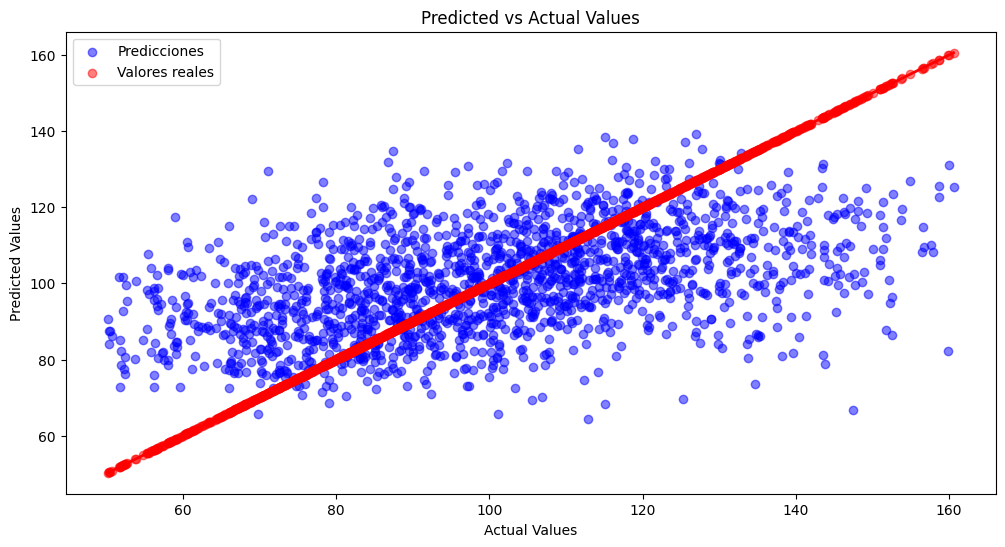

In [9]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Predicciones')
plt.scatter(y_test, y_test, alpha=0.5, color='red', label='Valores reales')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', lw=2)
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show() 